[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UM-RMRS/raster_tools/blob/main/notebooks/distance_module.ipynb)

# Raster Tools Distance Module
## This notebook demonstrates the functionality of the Raster Tools distance module 
by John Hogland 4/12/2023

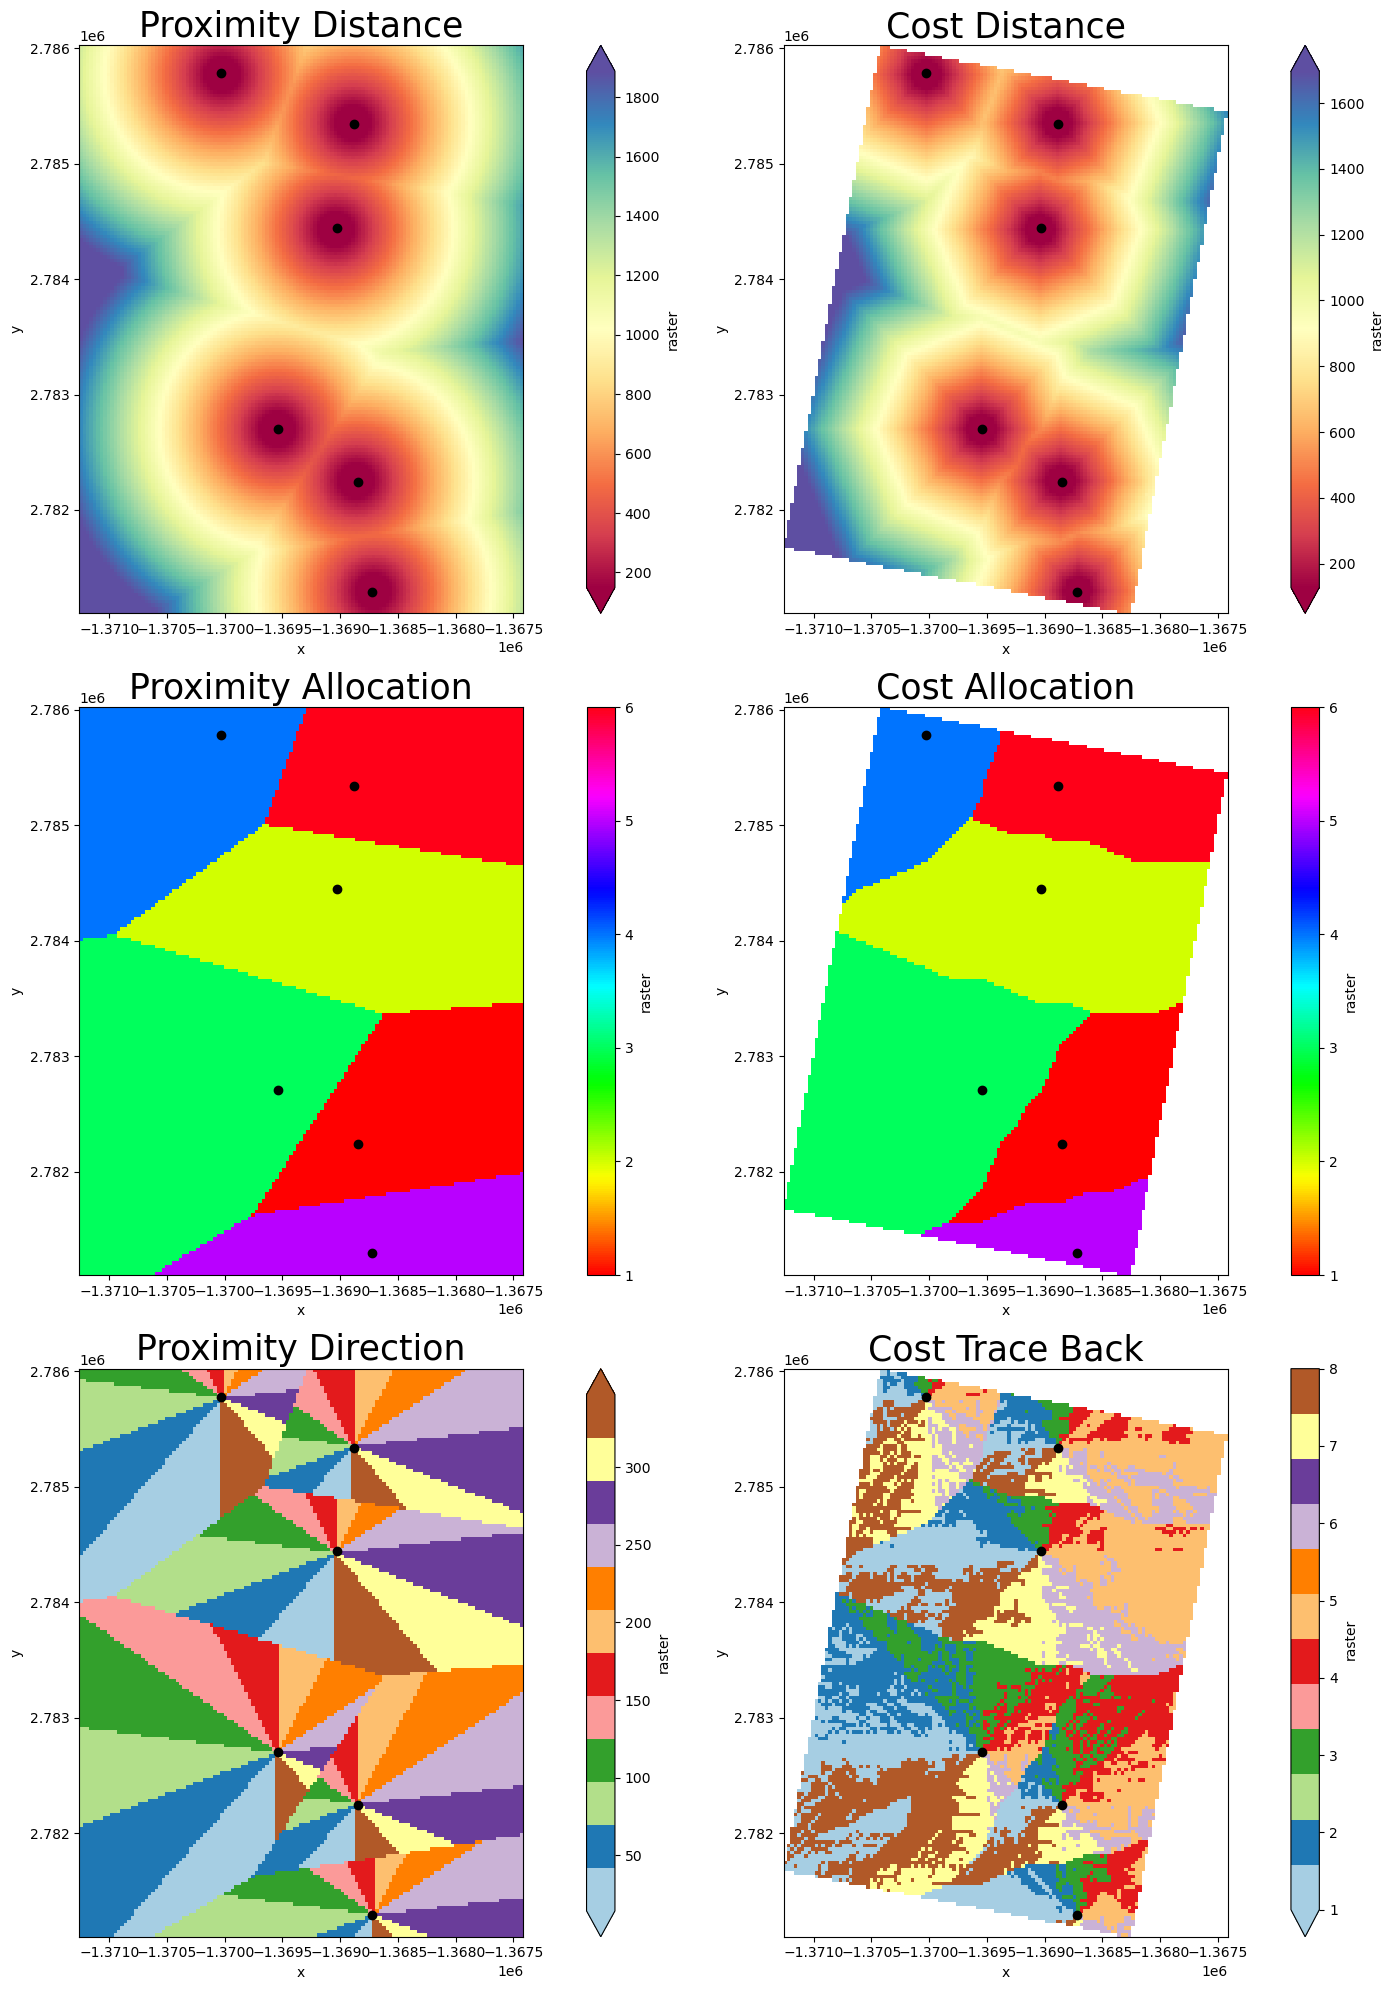
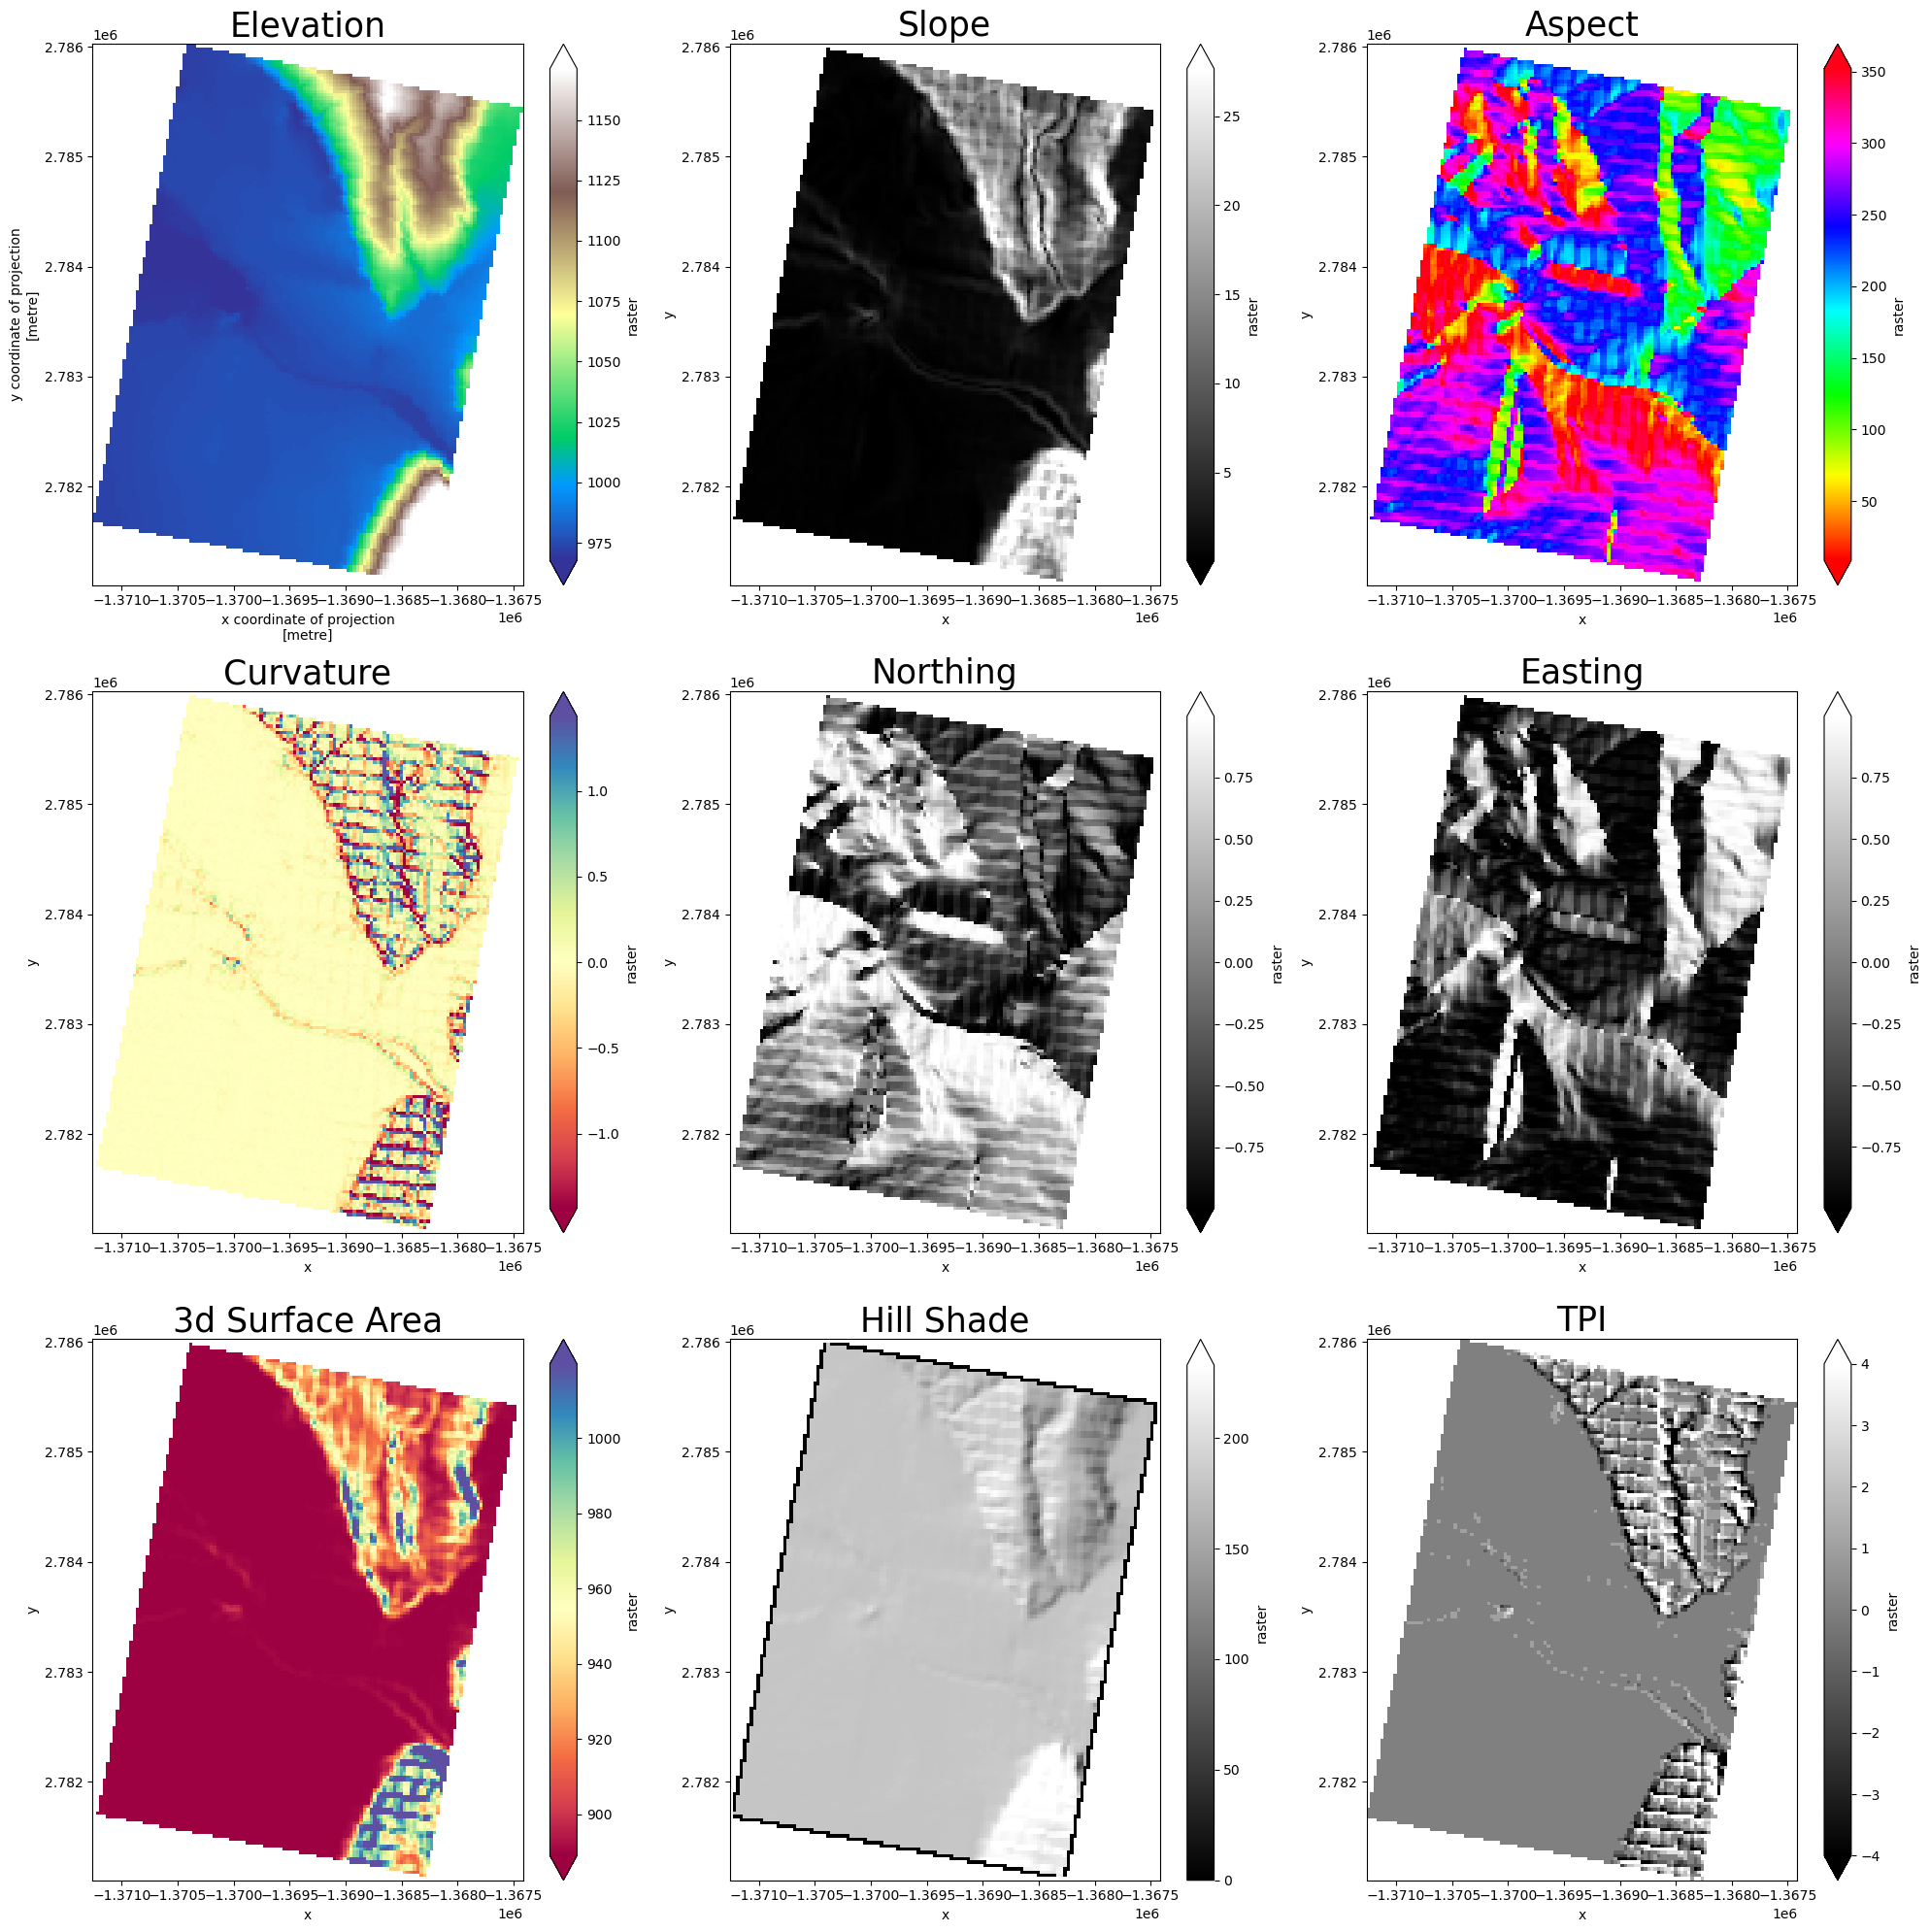

# Install software for Colab

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install --upgrade ipyleaflet
!pip install xarray_leaflet
!pip install raster_tools
!pip install py3dep
!pip install localtileserver

# The Process
In this notebook we download USGS 3dep products that are publicly available and use raster_tools to perform distance processing. At each step in the notebook we will discuss various aspects of the data, processing techniques, and visualization. After completing this notebook you should be very familiar with how to use the distance module.
## Steps
- 1. Create an area of interest (Missoula MT; 46.8721° N, 113.9940° W)
- 2. Use py3dep to download the dem for the area of interest
- 3. Create 6 random points within the boundary of the DEM
- 4. transform point locations and dem into various distance derivatives (e.g., from proximity and cost distance)
- 5. Visualize outputs

## Step 1: Create an area of interest (Missoula MT; 46.8721° N, 113.9940° W)
### Import various packages

In [ ]:
import py3dep
import geopandas as gpd
import numpy as np
from raster_tools import distance, Raster, Vector
from shapely.geometry import shape

### Define area of interest (AOI) using the coordinates of Missoula MT

In [ ]:
loc = {"type": "Point", "coordinates": [-113.994, 46.8721]}

geom = shape(loc)
geom_buff = gpd.GeoSeries(
    geom.buffer(0.02), crs="EPSG:4326"
)  # buffer out 0.02 degrees to get an area
geom_buff.explore()  # visualize

## Step 2: Get DEM data from USGS wms servers
### Create a get_3dep_data function to download USGS data and return a Raster object

In [ ]:
def get_3dep_data(sgeo, srv="DEM", res=30, out_crs=None):
    """
    downloads 3dep data from a specified service and resolution and returns a raster object

    sgeo: object, polygon | mulipolygon | bounding box [minx, miny, maxx, maxy] used to extract data (WGS 84 - EPSG:4326)
    srv: string, name of the 3dep service
    res: int, spatial resolution
    out_crs: object, optional crs used to project geopandas dataframe to a differnt crs

    return: raster object
    """
    ar = py3dep.get_map(srv, sgeo, resolution=res).expand_dims({"band": 1})
    out_rs = Raster(ar)
    if not out_crs is None:
        out_rs = Raster(out_rs.xdata.rio.reproject(out_crs))

    return out_rs

### Use get_3dep_data to download DEM for AOI (resolution 30 m) and save the raster.

In [ ]:
elv = get_3dep_data(
    list(geom_buff.total_bounds), srv="DEM", res=30
)  # data are returned in lat lon (WGS 84) with height in meters
elv = elv.save("elv.tif")

### Create 6 random source point locations. Distances will be calculated from those source point locations

In [ ]:
elv_p = Raster(
    elv.xdata.rio.reproject("EPSG:5070")
    )  # reproject to Albers to calculate distance
n = 6
bnds=elv.bounds
xdif=bnds[2]-bnds[0]
ydif=bnds[3]-bnds[1]
x = (np.random.random(n)*xdif)+bnds[0]
y = (np.random.random(n)*ydif)+bnds[1]
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x, y, crs=elv.crs))
gdf_p = gdf.to_crs('EPSG:5070') # to match projected elevation layer
loc = Vector(gdf_p) # turn the projected geodataframe into a Vector object
loc_rs=loc.to_raster(elv_p) # convert the point Vector object into a Raster object

## Visualize Point locations and Elevation raster using ipyleaflet

In [ ]:
from localtileserver import TileClient, get_leaflet_tile_layer
from ipyleaflet import Map, GeoData, LayersControl, basemaps, basemap_to_tiles

# Specify the name of the elevation raster
outname = "elv.tif"

# Create a TileClient from a raster file
client = TileClient(outname)

# Create ipyleaflet TileLayer from that server
t = get_leaflet_tile_layer(client, band=[1], name="Elevation")

# Create ipyleaflet map, add tile layer, and display
m = Map(center=client.center(), zoom=client.default_zoom)
wi = basemap_to_tiles(basemaps.Esri.WorldImagery)
wi.name = "ESRI World Imagery"
m.add(wi)
m.add(t)

# Create Geodata layer for locations and add to the display
geo_data = GeoData(geo_dataframe = gdf,
                   style={'color': 'yellow', 'fillColor': 'yellow'},
                   name = 'Source Locations')

m.add_layer(geo_data)

# add the layer control
control = LayersControl(position="topright")
m.add_control(control)
m

### Create proximity rasters
Proximity analysis calculates the distance from source locations given a defined estimation technique. Note, source locations should be projected to estimate distances. The outputs from the proximity analysis include:
- ds = distance
- al = allocation
- dr = direction raster

In [ ]:
ds,al,dr=distance.proximity_analysis(loc_rs)

### Create cost distance raster
Cost distance analysis calculates the cost weighted surface distance from source locations. Note, source locations and elevation surfaces should be projected to estimate distances. The outputs from the cost distance analysis include:
- cds = cost distance
- cdr = cost trace back
- cal = cost allocation

In [ ]:
cst = elv_p>-9999 # cost = to 1
cds,cdr,cal = distance.cost_distance_analysis(cst,loc_rs,elv_p)

### Visualize distance rasters using subplot and matplotlib

In [ ]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(figsize=(20, 20), ncols=2, nrows=3, tight_layout=True)

rslst = [ds,cds,al,cal,dr,cdr]
clms = [
    "Proximity Distance",
    "Cost Distance",
    "Proximity Allocation",
    "Cost Allocation",
    "Proximity Direction",
    "Cost Trace Back",
]
cramp = [
    plt.cm.Spectral,
    plt.cm.Spectral,
    plt.cm.hsv,
    plt.cm.hsv,
    plt.cm.Paired,
    plt.cm.Paired
]
for x in range(len(clms)):
    c = x % 2
    r = x // 2
    p1=gdf_p.plot(ax=axes[r,c],color='black',zorder=1)
    rslst[x].plot(ax=p1, robust=True, cmap=cramp[x],zorder=0)
    axes[r, c].set_title(clms[x], fontdict={"fontsize": 25, "fontweight": 3})

# This ends the Raster Tools distance module notebook
## Check out the other notebooks:
- https://github.com/UM-RMRS/raster_tools/blob/main/notebooks/README.md
## References
- Raster-Tools GitHub: https://github.com/UM-RMRS/raster_tools
- Hogland's Spatial Solutions: https://sites.google.com/view/hoglandsspatialsolutions/home
- Dask: https://dask.org/
- Geopandas:https://geopandas.org/en/stable/
- Xarray: https://docs.xarray.dev/en/stable/
- Jupyter: https://jupyter.org/
- Anaconda:https://www.anaconda.com/
- VS Code: https://code.visualstudio.com/
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/
- numpy:https://numpy.org/
- matplotlib:https://matplotlib.org/
- folium: https://python-visualization.github.io/folium/
- pandas: https://pandas.pydata.org/
- sklearn: https://scikit-learn.org/stable/index.html